In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [261]:
df = pd.read_csv('../data/responseFile_1.csv')

In [262]:
df.head()

,Elapsed Time (ms),Response Time (ms),Alphabet,Correct,Error Type,Pitch,Yaw,Roll
0,1267,1267,P,Yes,None,359.6631,184.4655,355.5853
1,3334,1322,O,Yes,None,357.3612,176.5136,356.9228
2,4805,790,N,Yes,None,355.9378,185.2690,356.4589
3,6994,971,C,Yes,None,354.7144,167.1992,355.7530
4,8762,738,P,Yes,None,357.5221,185.2620,353.8421


In [263]:
global_attentive = 0.5
# if correct us yes increase attention by 0.1 else decrease by 0.1
for index, row in df.iterrows():
    if row[' Correct'] == ' Yes':
        global_attentive = min(0.8, global_attentive * 1.1)
    else:
        global_attentive = max(0.2, global_attentive * 0.5)
    df.at[index, 'attentive'] = global_attentive

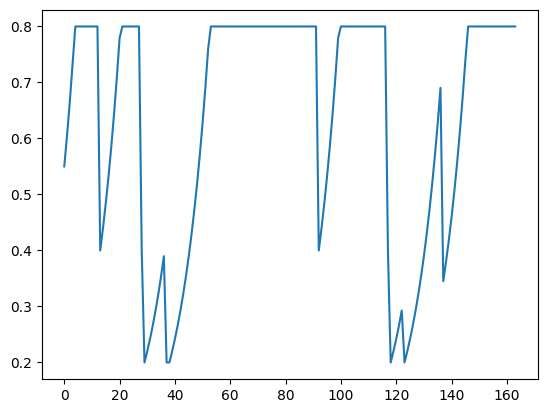

In [264]:
plt.plot(df.attentive)

In [265]:

def adjust_values_with_improved_logic(df, bool_col_name, start_value=0.5):
    """
    Adjusts a running value based on boolean values in a DataFrame column,
    with more significance given to False values and preventing values from
    getting stuck at 0.9 due to predominant True values.
    
    Parameters:
    - df: pandas DataFrame containing the boolean column.
    - bool_col_name: the name of the column with boolean values.
    - start_value: the starting value for the adjustment process.
    
    Returns:
    - A list of adjusted values with more complex adjustments.
    """
    current_value = start_value
    adjusted_values = []
    prev_bool = None
    consecutive_count = 1
    increase_factor = 0.05
    decrease_factor = 0.3

    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        current_bool = True if row[bool_col_name] == ' Yes' else False
        if current_bool == prev_bool:
            consecutive_count += 1
        else:
            consecutive_count = 1  # Reset count if the sequence breaks
        
        if current_bool:
            # Apply a non-linear increase based on the distance from the upper bound
            increment = increase_factor * (0.9 - current_value) * np.sqrt(consecutive_count)
            current_value += min(increment, 0.9 - current_value)
        else:
            # Apply a more aggressive and non-linear decrease for False values
            decrement = decrease_factor * (current_value - 0.1) * np.sqrt(consecutive_count)
            current_value -= min(decrement, current_value - 0.1)
        
        # Ensure current_value stays within bounds
        current_value = max(0.1, min(0.9, current_value))
        adjusted_values.append(current_value)
        
        prev_bool = current_bool
    
    return adjusted_values


In [266]:
import pandas as pd

# Define or import your adjust_values_with_improved_logic function here

# List of file paths
file_paths = [
    '../data/responseFile_1.csv',
    # '../data/responseFile_2.csv',
    '../data/responseFile_3.csv',
    '../data/responseFile_4.csv',
    '../data/responseFile_5.csv',
    '../data/responseFile_6.csv',
    '../data/responseFile_7.csv'
]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each file path
for file_path in file_paths:
    # Read the current CSV file
    df = pd.read_csv(file_path)
    
    # Apply the function to adjust 'attention' based on 'Correct' column
    df['attention'] = adjust_values_with_improved_logic(df, ' Correct', start_value=0.5)
    
    # Append the processed DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list into one
combined_df = pd.concat(dfs, ignore_index=True)

# Now combined_df contains all data processed and combined

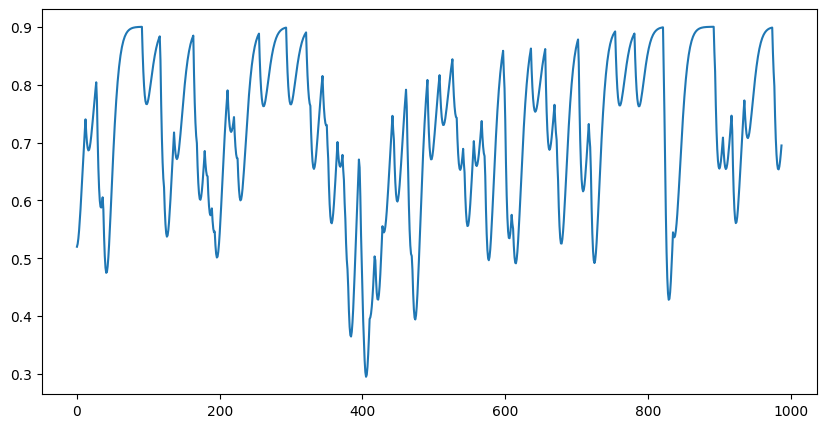

In [267]:
plt.figure(figsize=(10, 5))
combined_df['ema_attention'] = combined_df['attention'].ewm(span=10, adjust=False).mean()
plt.plot(combined_df.ema_attention)

In [268]:
combined_df[' Pitch'] = round(((combined_df[' Pitch'] + 180) % 360), 2)
combined_df[' Roll'] = round(((combined_df[' Roll'] + 180) % 360), 2)
features = combined_df[[' Pitch', ' Roll', ' Yaw']]
labels = combined_df['ema_attention']

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
features_scaled = sc.fit_transform(features)

# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

In [193]:
# fit a random forrest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

regr = RandomForestRegressor(100, random_state=0)#, max_depth=7, n_jobs=-1, verbose=1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.12289163515099011

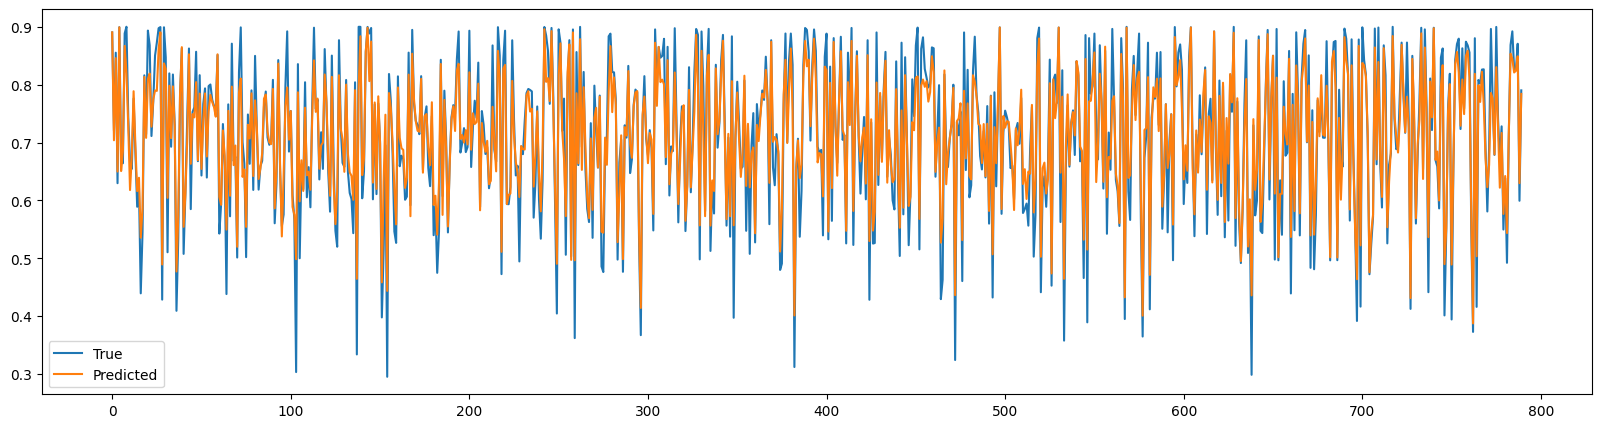

In [194]:
train_preds = regr.predict(X_train)
plt.figure(figsize=(20, 5))
plt.plot(y_train.values, label='True')
plt.plot(train_preds, label='Predicted')
plt.legend()

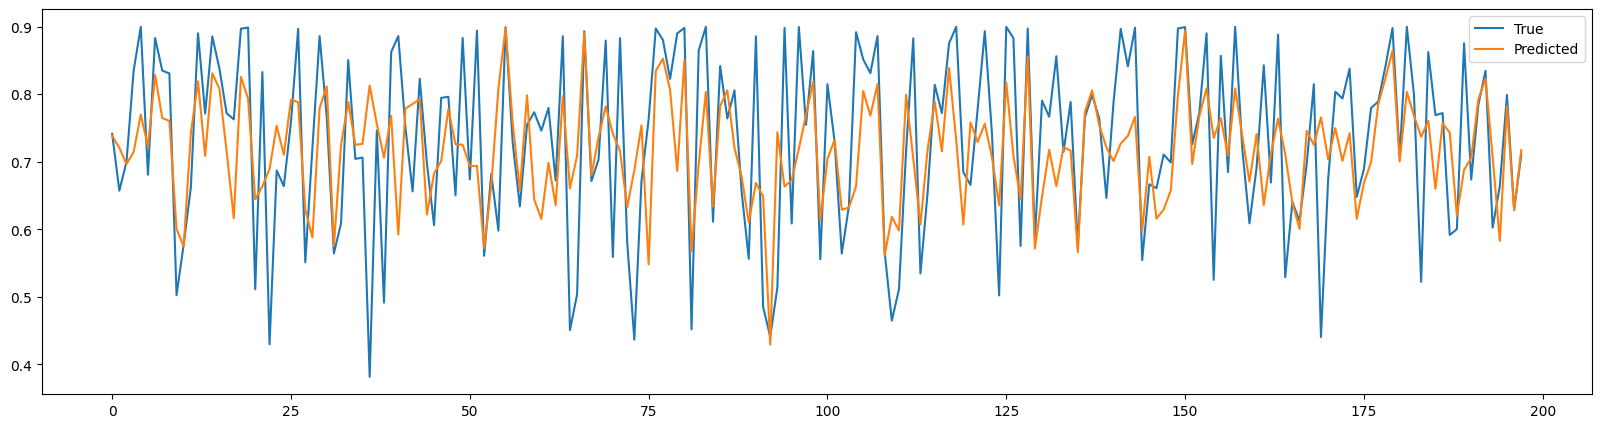

In [195]:
plt.figure(figsize=(20, 5))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()

<Axes: >

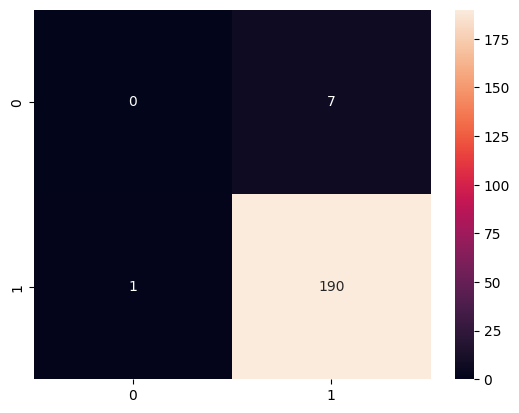

In [175]:
# use y_test and y_pred to make a confusion matrix, > 0.5 is attentive and < 0.5 is not attentive
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_binary = y_pred > 0.5
y_test_binary = y_test > 0.5
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d")


In [197]:
from keras.utils import timeseries_dataset_from_array
import tensorflow as tf

In [270]:
features_scaled = features / 360
features_scaled.shape

(988, 3)

In [271]:
features_scaled

,Pitch,Roll,Yaw
0,0.499056,0.487750,0.512404
1,0.492667,0.491444,0.490316
2,0.488722,0.490167,0.514636
3,0.485306,0.488194,0.464442
4,0.493111,0.482889,0.514617
...,...,...,...
983,0.484333,0.474778,0.505176
984,0.484000,0.474306,0.505056
985,0.485611,0.475444,0.503667
986,0.483944,0.474500,0.504412


In [272]:

gen = timeseries_dataset_from_array(np.asarray(features), np.asarray(combined_df['ema_attention']), 10, batch_size=10000000)

In [273]:
x , y = next(iter(gen))
x.shape, y.shape

(TensorShape([979, 10, 3]), TensorShape([979]))

In [274]:
# Assuming stacked_features is already defined and available.
# stacked_features.shape[2] should represent the number of features in each input sequence.

# Define the input layer with the shape (10, number of features)
input_layer = tf.keras.layers.Input(shape=(10, 3))

# Define a stack of LSTM layers in a sequential fashion
lstm_layer1 = tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh', recurrent_dropout=0.2, dropout=0)(input_layer)
lstm_layer2 = tf.keras.layers.LSTM(32, activation='tanh', recurrent_dropout=0.2, dropout=0)(lstm_layer1)

# Define the output layer
hidden_layer = tf.keras.layers.Dense(32, activation='relu')(lstm_layer2)
droput_layer = tf.keras.layers.Dropout(0.1)(hidden_layer)
hidden_layer2 = tf.keras.layers.Dense(32, activation='relu')(droput_layer)
droput_layer2 = tf.keras.layers.Dropout(0.1)(hidden_layer2)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(droput_layer2)

# Create the sequential model
sequential_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

sequential_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 32)            4608      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0   

In [275]:
# Compile the model
sequential_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
)


base_history = sequential_model.fit(x, y, batch_size=32, epochs=5000)

Epoch 1/5000
31/31 [==============================] - 6s 10ms/step - loss: 24.7252
Epoch 2/5000
31/31 [==============================] - 0s 10ms/step - loss: 18.4277
Epoch 3/5000
31/31 [==============================] - 0s 9ms/step - loss: 18.3662
Epoch 4/5000
31/31 [==============================] - 0s 10ms/step - loss: 18.0887
Epoch 5/5000
31/31 [==============================] - 0s 10ms/step - loss: 17.7085
Epoch 6/5000
31/31 [==============================] - 0s 10ms/step - loss: 17.8257
Epoch 7/5000
31/31 [==============================] - 0s 10ms/step - loss: 17.7020
Epoch 8/5000
31/31 [==============================] - 0s 10ms/step - loss: 17.6848
Epoch 9/5000
31/31 [==============================] - 0s 10ms/step - loss: 17.4753
Epoch 10/5000
31/31 [==============================] - 0s 10ms/step - loss: 17.4506
Epoch 11/5000
31/31 [==============================] - 0s 11ms/step - loss: 16.8950
Epoch 12/5000
31/31 [==============================] - 0s 10ms/step - loss: 16.8101
Ep

In [241]:
base_history = sequential_model.fit(x, y, batch_size=32, epochs=5000)

Epoch 1/5000
31/31 [==============================] - 0s 10ms/step - loss: 7.6233
Epoch 2/5000
31/31 [==============================] - 0s 10ms/step - loss: 7.7388
Epoch 3/5000
31/31 [==============================] - 0s 13ms/step - loss: 7.8292
Epoch 4/5000
31/31 [==============================] - 0s 10ms/step - loss: 7.5223
Epoch 5/5000
31/31 [==============================] - 0s 10ms/step - loss: 7.4185
Epoch 6/5000
31/31 [==============================] - 0s 10ms/step - loss: 7.6658
Epoch 7/5000
31/31 [==============================] - 0s 12ms/step - loss: 7.4527
Epoch 8/5000
31/31 [==============================] - 0s 10ms/step - loss: 8.0297
Epoch 9/5000
31/31 [==============================] - 0s 10ms/step - loss: 7.7791
Epoch 10/5000
31/31 [==============================] - 0s 10ms/step - loss: 7.6649
Epoch 11/5000
31/31 [==============================] - 0s 10ms/step - loss: 7.6440
Epoch 12/5000
31/31 [==============================] - 0s 11ms/step - loss: 7.6236
Epoch 13/5000

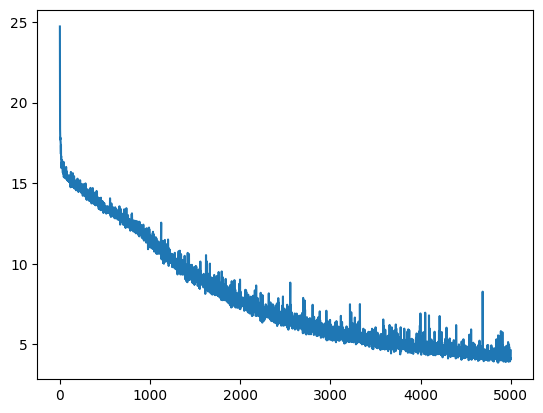

In [276]:
plt.plot(base_history.history['loss'], label='loss')

31/31 [==============================] - 1s 3ms/step


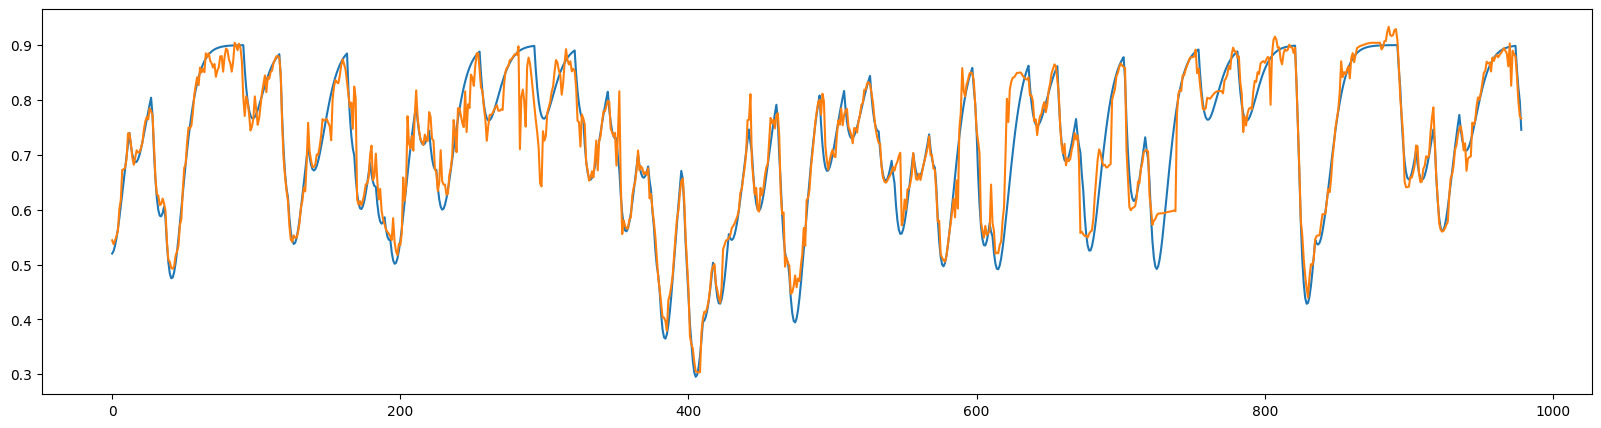

In [277]:
plt.figure(figsize=(20, 5))
plt.plot(y)
plt.plot(sequential_model.predict(x))

In [278]:
from datetime import datetime

time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
unique_file_name = '../models/LSTM-' + time + '.h5'
sequential_model.save(unique_file_name)

c:\Users\muham\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 3ms/step


<Axes: >

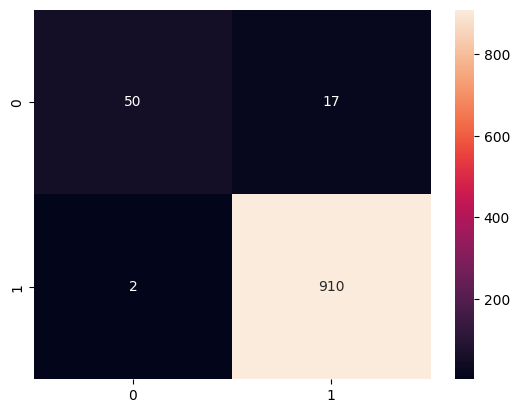

In [284]:
y_pred = sequential_model.predict(x)
y_pred_binary = y_pred > 0.5
y_test_binary = y > 0.5
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d")
